In [100]:
import os
import math

import librosa
import argparse
import numpy as np
import scipy.io.wavfile as wav

In [101]:
import scipy
from utils.estnoise_ms import * 
from utils.utils import * 

In [102]:
def MMSE_STSA():
    """Speech Enhancement using A Spectral Amplitude Estimator
    """
    path_clean_test = 'G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\clean.wav'
    path_noisy_test ='G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\noisy_white_3dB.wav'
    output_path_estimated_noisy_test='G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\clean_estimated_MMSE_STSA_test_new.wav'
    
    sr, clean_test = scipy.io.wavfile.read(str('G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\')+"clean.wav")
    sr, noisy_test  = scipy.io.wavfile.read(str('G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\')+"noisy_white_3dB.wav")
     
   
    noisy_test= np.array(noisy_test, dtype=float)
    
    clean_test= np.array(clean_test, dtype=float)

    maxPosteriorSNR= 100   
    minPosteriorSNR= 1
    
    NFFT=256 
    hop_length_sample = 128 
    winfunc = 'hamming'     
    #NFFT=args.num_FFT
    #hop_length_sample = args.hop_size
   # winfunc = args.window
    
    smoothFactorDD=0.99

    # the variance of the speech; lambda_x(k)
    #noisy
    stft_noisy_test = librosa.stft(noisy_test, n_fft=NFFT, hop_length=hop_length_sample, window=winfunc)   
    magnitude_noisy_test, phase_noisy_test = divide_magphase(stft_noisy_test, power=1)
        
    pSpectrum = magnitude_noisy_test**2                   
    
    # estimate the variance of the noise using minimum statistics noise PSD estimation ; lambda_d(k). 
    estNoise = estnoisem(pSpectrum,hop_length_sample/sr)     
    estNoise = estNoise
    
    aPosterioriSNR=pSpectrum/estNoise                    
    aPosterioriSNR=aPosterioriSNR
    aPosterioriSNR[aPosterioriSNR > maxPosteriorSNR] = maxPosteriorSNR
    aPosterioriSNR[aPosterioriSNR < minPosteriorSNR] = minPosteriorSNR

    previousGainedaPosSNR=1 
    (nFrames,nFFT2) = pSpectrum.shape                
    totalGain =[]
    for i in range(nFFT2):                         
        aPosterioriSNR_frame = aPosterioriSNR[:,i]                  
        
        #operator [2](52)
        oper=aPosterioriSNR_frame-1
        oper[oper < 0] = 0 
        smoothed_a_priori_SNR = smoothFactorDD * previousGainedaPosSNR + (1-smoothFactorDD) * oper
        
        #V for MMSE estimate ([2](8)) 
        V=smoothed_a_priori_SNR*aPosterioriSNR_frame/(1+smoothed_a_priori_SNR)            
        
        #Calculate Gain function which results from the MMSE [2](7),(12).
        gain= smoothed_a_priori_SNR/(1+smoothed_a_priori_SNR)  
        if any(V<1):
            gain[V<1] = (math.gamma(1.5) * np.sqrt(V[V<1])) / aPosterioriSNR_frame[V<1] * np.exp(-1 * V[V<1] / 2) * ((1 + V[V<1]) * bessel(0, V[V<1] / 2) + V[V<1] * bessel(1, V[V<1] / 2))
        
        previousGainedaPosSNR = (gain**2) * aPosterioriSNR_frame
        totalGain.append(gain)
    
    totalGain=np.array(totalGain)

    magnitude_estimated_clean = totalGain.T * magnitude_noisy_test
    stft_reconstructed_clean = merge_magphase(magnitude_estimated_clean, phase_noisy_test)
    signal_reconstructed_clean =librosa.istft(stft_reconstructed_clean, hop_length=hop_length_sample, window=winfunc)
    signal_reconstructed_clean=signal_reconstructed_clean.astype('int16')
    
    wav.write(output_path_estimated_noisy_test,sr,signal_reconstructed_clean)
    signal_reconstructed_clean=np.array(signal_reconstructed_clean, dtype=float)
   #display signals, spectrograms
    show_signal(clean_test,noisy_test,signal_reconstructed_clean,sr)
    show_spectrogram(clean_test,noisy_test, signal_reconstructed_clean,sr,NFFT,hop_length_sample)
    return signal_reconstructed_clean

In [115]:
def parse_args():
    parser = argparse.ArgumentParser(description='MMSE-STSA Speech Enhancement')
    parser.add_argument('--datasets_dir', type=str, default='G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\',
                        help='')
    parser.add_argument('--input_clean', type=str, default='G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\clean.wav',
                        help='datasets/clean_file_name.wav')
    parser.add_argument('--input_noisy', type=str, default='G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\noisy_white_3dB.wav',
                        help='datasets/noisy_file_name.wav')
    parser.add_argument('--output_file', type=str, default='G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\clean_estimated_MMSE_STSA_test.wav',
                        help='datasets/output_file_name.wav')
    parser.add_argument('--num_FFT', type=int, default='256',
                        help='')
    parser.add_argument('--hop_size', type=int, default='128',
                        help='')
    parser.add_argument('--window', type=str, default='hamming',
                        help='')
    return check_args(parser.parse_args())

In [116]:
def check_args(args):
    if not os.path.exists(args.datasets_dir):
        os.makedirs(args.datasets_dir)
    assert args.num_FFT >= 1, 'number of FFT size must be larger than or equal to one'
    assert args.hop_size < args.num_FFT, 'hop size must be smaller than number of FFT size'
    return args

In [117]:
args = parse_args()
MMSE_STSA(args)

usage: ipykernel_launcher.py [-h] [--datasets_dir DATASETS_DIR]
                             [--input_clean INPUT_CLEAN]
                             [--input_noisy INPUT_NOISY]
                             [--output_file OUTPUT_FILE] [--num_FFT NUM_FFT]
                             [--hop_size HOP_SIZE] [--window WINDOW]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Venkatesan R\AppData\Roaming\jupyter\runtime\kernel-9457ac8f-867c-4959-9b0f-69863ec3973a.json


SystemExit: 2

G:\New folder\lib\site-packages\IPython\core\interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


G:\New folder\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


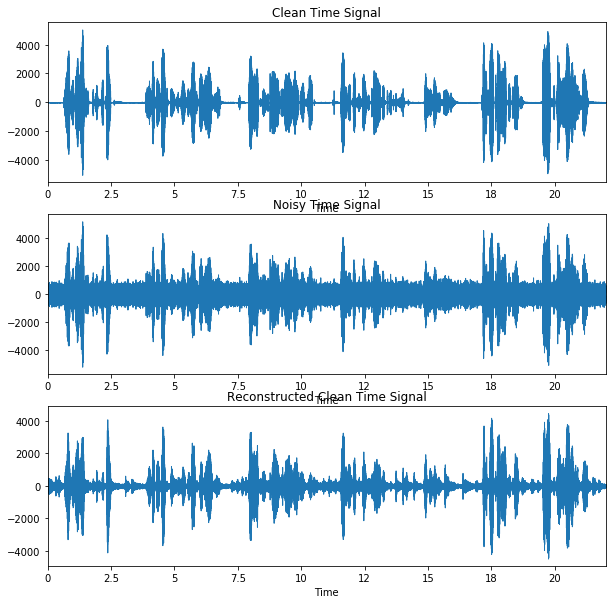

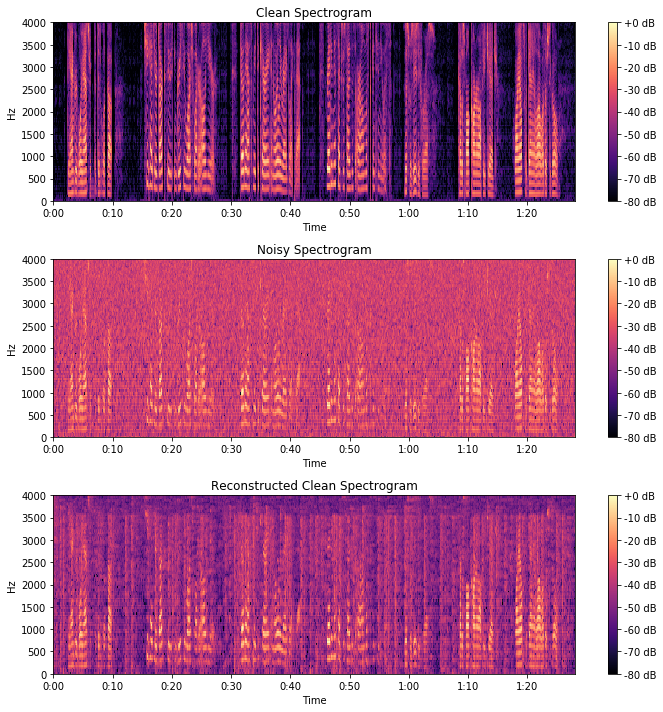

array([-238.,  339., -260., ...,   -7.,  -21.,   28.])

In [104]:
MMSE_STSA()

In [31]:
path_clean_test='G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\clean.wav'
'G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\noisy_white_3dB.wav'
'G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\clean_estimated_MMSE_STSA_test.wav'

'G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\clean_estimated_MMSE_STSA_test.wav'

In [42]:
(sr, clean_test) = librosa.load(path_clean_test)

In [43]:
sr

array([-8.7028508e-05, -8.1085491e-05, -4.5198427e-05, ...,
       -2.9984072e-05, -4.3874883e-05,  0.0000000e+00], dtype=float32)

In [44]:
clean_test

22050

In [85]:
import scipy
sr, clean_test = scipy.io.wavfile.read(str('G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\')+"clean.wav")
sr, noisy_test  = scipy.io.wavfile.read(str('G:\\speech segregation\\Speech_Enhancement_MMSE-STSA-master\\Speech_Enhancement_MMSE-STSA-master\\datasets\\')+"noisy_white_3dB.wav")
   

G:\New folder\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [89]:
noisy_test= np.array(noisy_test, dtype=float)
noisy_test

array([-467.,  606., -543., ...,  116.,   96.,  -72.])

In [90]:
clean_test= np.array(clean_test, dtype=float)
clean_test

array([-3.,  0.,  4., ...,  4.,  6., -1.])

In [91]:
NFFT=256 
hop_length_sample = 128 
winfunc = 'hamming'     
    #NFFT=args.num_FFT
    #hop_length_sample = args.hop_size
   # winfunc = args.window
    
smoothFactorDD=0.99

    # the variance of the speech; lambda_x(k)
    #noisy
stft_noisy_test = librosa.stft(noisy_test, n_fft=NFFT, hop_length=hop_length_sample, window=winfunc)